# Navarro-Frank-White halo potential

In [1]:
import os
from math import pi
from autocvd import autocvd
autocvd(num_gpus = 1)
# # os.environ["CUDA_VISIBLE_DEVICES"] = "2, 3"  # Use only the first GPU
from typing import Optional, Tuple, Callable, Union, List
from functools import partial
from math import radians


import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
from jax import vmap, jit
from jax import random
jax.config.update("jax_enable_x64", True)

import numpy as np
from astropy import units as u
from astropy import constants as c
from astropy.coordinates import SkyCoord


import odisseo
from odisseo import construct_initial_state
from odisseo.integrators import leapfrog
from odisseo.dynamics import direct_acc, DIRECT_ACC, DIRECT_ACC_MATRIX, DIRECT_ACC_LAXMAP, DIRECT_ACC_FOR_LOOP
from odisseo.option_classes import SimulationConfig, SimulationParams, NFWParams, PlummerParams, NFW_POTENTIAL
from odisseo.initial_condition import Plummer_sphere, ic_two_body, sample_position_on_sphere, inclined_circular_velocity, sample_position_on_circle, inclined_position
from odisseo.utils import center_of_mass
from odisseo.time_integration import time_integration
from odisseo.units import CodeUnits
from odisseo.visualization import create_3d_gif, create_projection_gif, energy_angular_momentum_plot, plot_sky_projection
from odisseo.potentials import NFW 

plt.rcParams.update({
    'font.size': 20,
    'axes.labelsize': 20,
    'xtick.labelsize': 13,
    'ytick.labelsize': 13,
    'legend.fontsize': 15,
})

## Plummer Sphere

In [2]:
code_length = 10.0 * u.kpc
code_mass = 1e8 * u.Msun
G = 1 
code_units = CodeUnits(code_length, code_mass, G=G)

In [3]:
# Define the 
config = SimulationConfig(N_particles=int(5_000), 
                          return_snapshots=True, 
                          num_snapshots=100, 
                          num_timesteps=1000, 
                          external_accelerations=(NFW_POTENTIAL, ), 
                          acceleration_scheme=DIRECT_ACC_MATRIX,
                          batch_size=50_000,
                          softening=(0.1 * u.kpc).to(code_units.code_length).value) #default values

params = SimulationParams(t_end = (10 * u.Gyr).to(code_units.code_time).value,  
                          Plummer_params= PlummerParams(Mtot=(1e8 * u.Msun).to(code_units.code_mass).value,
                                                        a=(1 * u.kpc).to(code_units.code_length).value),
                          NFW_params = NFWParams(Mvir=(1e12 * u.Msun).to(code_units.code_mass).value,
                                                 r_s = (20 * u.kpc).to(code_units.code_length).value,
                                                 ),
                          G=G, ) 

print(config)
print(params)

SimulationConfig(N_particles=5000, dimensions=3, return_snapshots=True, num_snapshots=100, fixed_timestep=True, num_timesteps=1000, softening=np.float64(0.010000000000000002), integrator=0, diffrax_solver=0, acceleration_scheme=2, batch_size=50000, double_map=False, external_accelerations=(0,), differentation_mode=1, num_checkpoints=100, progress_bar=False)
SimulationParams(G=1, t_end=np.float64(6.7070874092034565), Plummer_params=PlummerParams(a=np.float64(0.1), Mtot=np.float64(1.0)), NFW_params=NFWParams(Mvir=np.float64(10000.0), r_s=np.float64(2.0)), PointMass_params=PointMassParams(M=1.0), MN_params=MNParams(M=65000000000.0, a=3.0, b=0.28), PSP_params=PSPParams(M=4501365375.06545, alpha=1.8, r_c=1.9), Logarithmic_params=LogarithmicParams(v0=220.0, q=0.9))


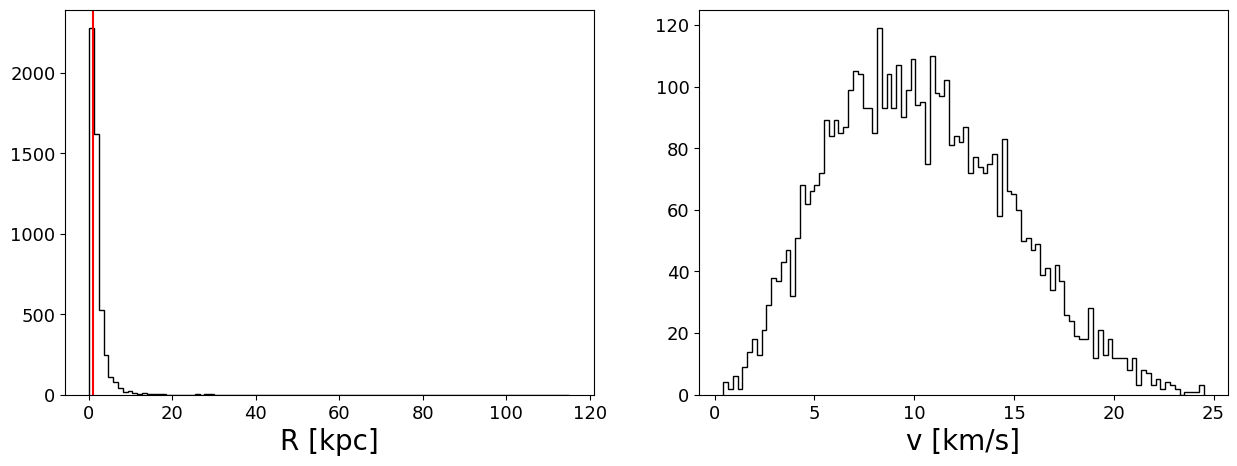

In [4]:
#set up the particles in the initial state
positions, velocities, mass = Plummer_sphere(key=random.PRNGKey(0), params=params, config=config)

#Plummer sphere distribution
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(121)
ax.hist((jnp.linalg.norm(positions, axis=1) * code_units.code_length).to(u.kpc), bins=100, histtype='step', color='k')
ax.axvline((params.Plummer_params.a*code_units.code_length).to(u.kpc).value, color='r', label='Plummer a')
ax.set_xlabel('R [kpc]')

ax = fig.add_subplot(122)
ax.hist(jnp.linalg.norm((velocities * code_units.code_velocity).to(u.km/u.s).value, axis=1), bins=100, histtype='step', color='k')
ax.set_xlabel('v [km/s]')
plt.show()


In [5]:
#put the Plummer sphere in a ciruclar orbit around the NFW halo
rp=200*u.kpc.to(code_units.code_length)


#sampling the center of mass on the sphere
key = random.PRNGKey(42)
num_samples = 1                                             # Number of positions to generate, we only care about the center of mass
pos_com = sample_position_on_circle(key, rp, num_samples)   # Sample the position of the center of mass on a circle of radius rp
inclination = jnp.array(radians(40))                               # 30-degree inclination of the orbit
pos_com = inclined_position(pos_com, inclination)           # Rotate the center of mass position by the inclination angle
vel_com = jnp.zeros_like(pos_com)                           # Initialize velocities to zero, it dosen't matter because the acceleration depend only on the postion
state_com = construct_initial_state(pos_com, vel_com)

# Calculate the acceleration at the center of mass, because v_c = sqrt(rp*a) in circular motion
acc_com, _ = NFW(state_com, config, params, return_potential=True)
#modulus of the circular velocity at the center of mass
v_c = jnp.sqrt(jnp.linalg.norm(acc_com, axis=1) * rp)
#bulk motion to give to each particle of the Plummer sphere
vel_com = inclined_circular_velocity(pos_com, v_c, inclination)


# Add the center of mass position and velocity to the Plummer sphere particles
positions = positions + pos_com
velocities = velocities + vel_com

#initialize the initial state
initial_state = construct_initial_state(positions, velocities)

In [6]:
if config.return_snapshots: 
    snapshots = jax.block_until_ready(time_integration(initial_state, mass, config, params))
else:
    final_state = jax.block_until_ready(time_integration(initial_state, mass, config, params))


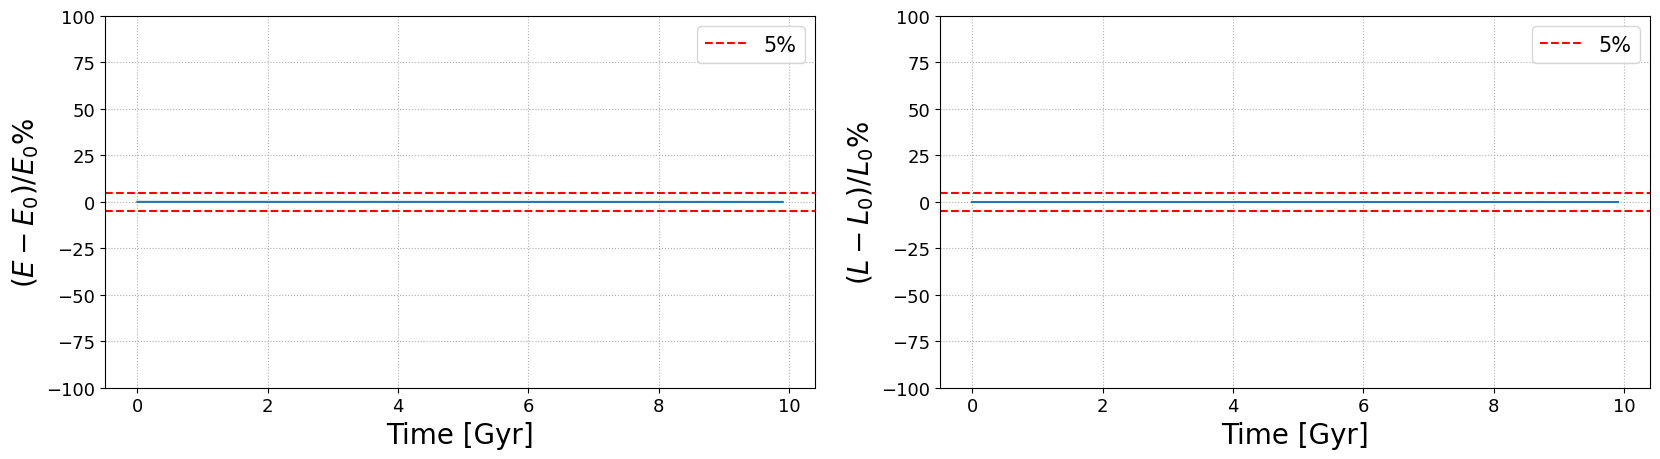

In [7]:
energy_angular_momentum_plot(snapshots, code_units, filename='./visualization/image/E_L_Plummer_in_NFWpotential.pdf')

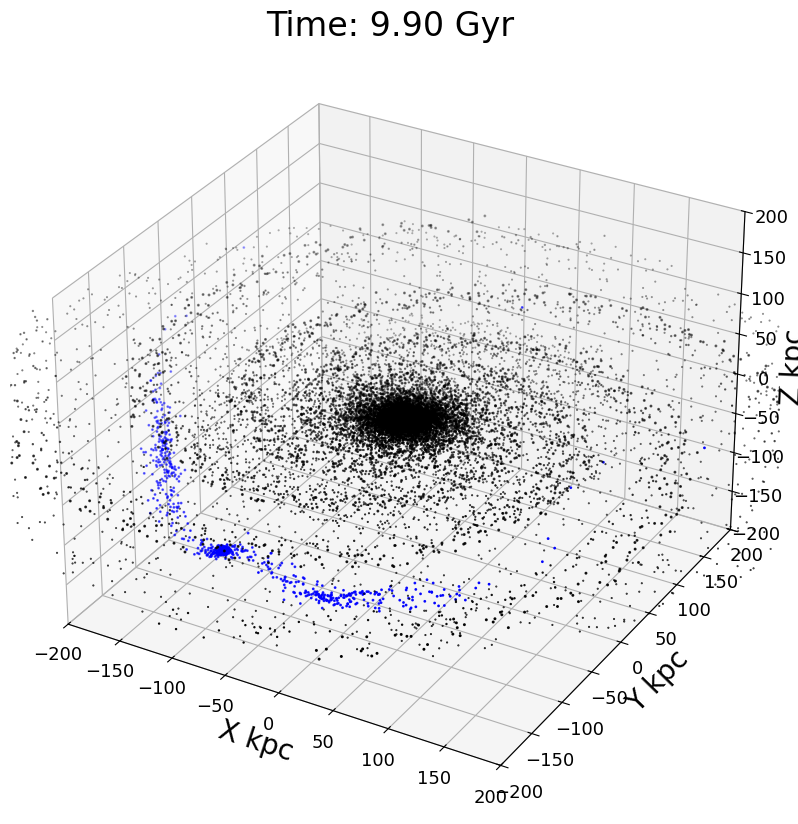

In [8]:
create_3d_gif(snapshots, 
              ax_lim=rp, 
              code_units=code_units, 
              plotting_units_length=u.kpc, 
              plot_units_time=u.Gyr, 
              filename='./visualization/gif/simulation_Plummer_in_NFWpotential.gif')

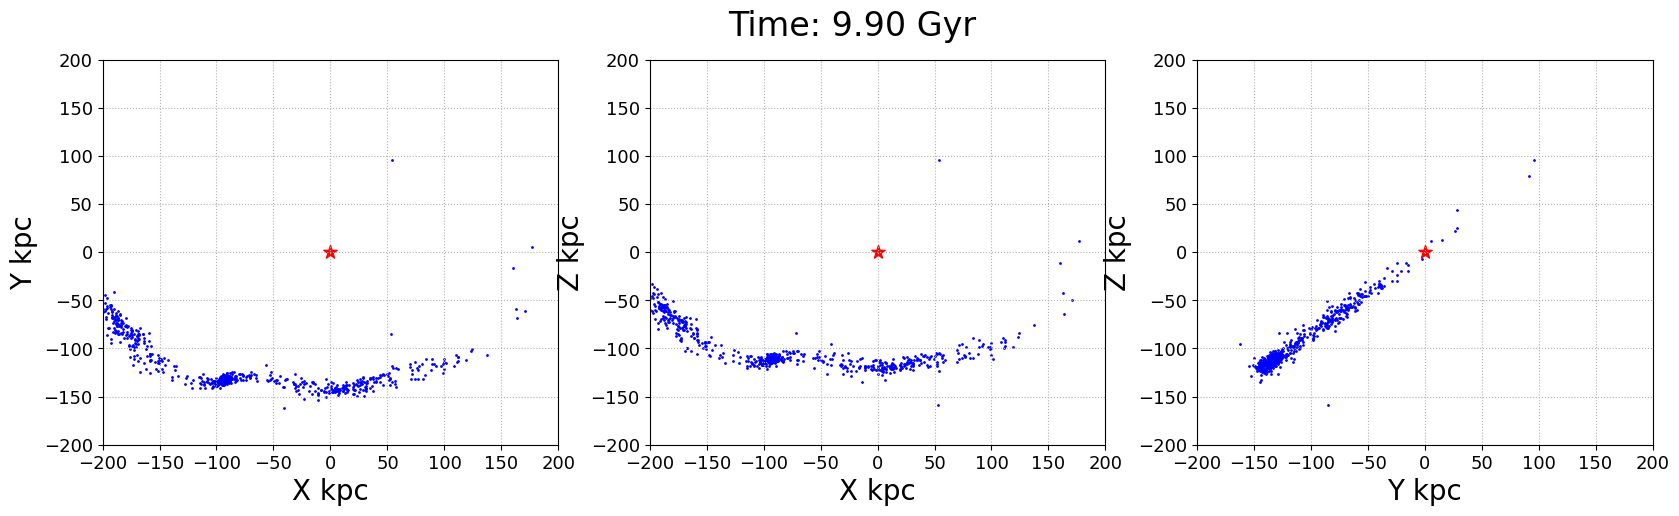

In [9]:
create_projection_gif(snapshots=snapshots,
                      ax_lim=rp, 
                      code_units=code_units, 
                      plotting_units_length=u.kpc, 
                      plot_units_time=u.Gyr, 
                      filename='./visualization/gif/simulation_projection_Plummer_in_NFWpotential.gif')

## Projection on the sky 

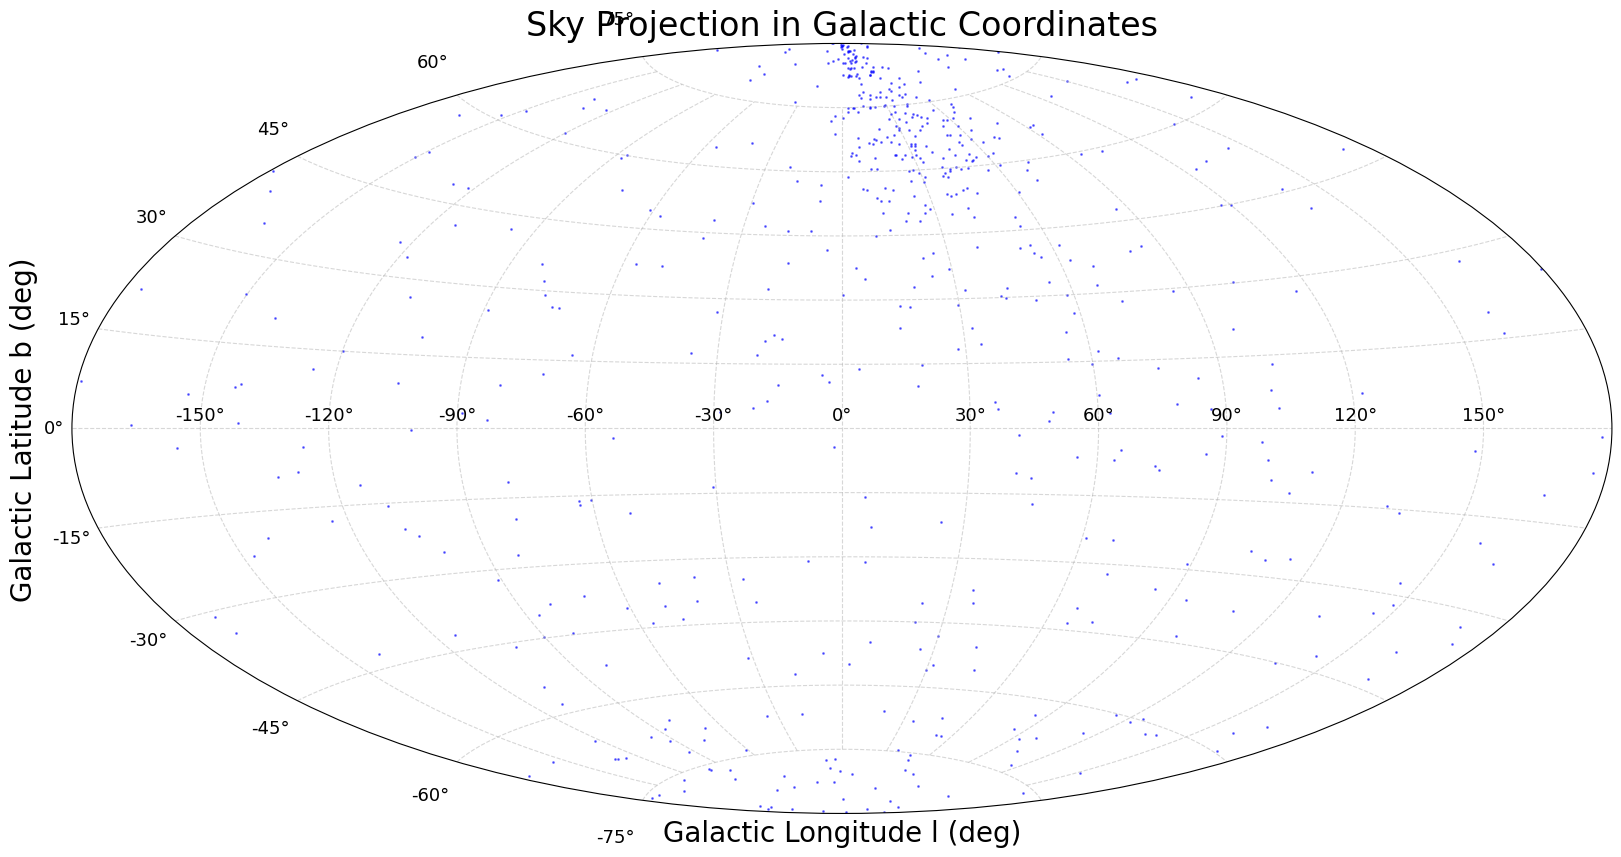

In [11]:
plot_sky_projection(snapshots=snapshots, code_units=code_units, plotting_units_length=u.kpc, filename=None)